In [27]:
import pandas as pd
import numpy as np
import shap
import torch
from torch import nn
import scipy.stats
import matplotlib.pyplot as plt
import plotly.express as px

import json
import xmltodict

import stable_baselines3

from agents.actor_critic_agent import CustomActorCritic
from agents.option_networks import ReluNetwork


In [22]:
BASE_FOLDER = './evaluations'
MODEL_HIGH = "actor_critic_custom-2way-single-intersection-high_50000_steps"
MODEL_LOW = "actor_critic_custom-2way-single-intersection-low_50000_steps"

In [13]:
def to_tensor(obs):
    obs = np.asarray(obs)
    obs = torch.from_numpy(obs).float()
    return obs

def load_data(prefix, traffic):
    df_single_episode = pd.read_csv(f'{BASE_FOLDER}/{prefix}_{traffic}_1_episode.csv')
    df_single_episode = df_single_episode.set_index('step')
    df_single_episode = df_single_episode.drop(columns=['cumulative_reward'])
    
    df_multiple_episodes = pd.read_csv(f'{BASE_FOLDER}/{prefix}_{traffic}_100_episode.csv')
    df_multiple_episodes = df_multiple_episodes.set_index('episode')
    # df_multiple_episodes = df_multiple_episodes.drop(columns=['cumulative_reward'])
    return df_single_episode, df_multiple_episodes

def compare_datasets(datasets):
    results = []
    for name, df in datasets:
        data = {
            'dataset': name,
            'avg_cumulative_reward': np.mean(df.cumulative_reward.to_list()),
            # 'mean_waiting_time': np.mean(df.mean_waiting_time.to_list()),
            
            'avg_travel_time': np.mean(df.avg_travel_time.to_list()),
            'avg_time_loss': np.mean(df.avg_time_loss.to_list()),
            'avg_waiting_time': np.mean(df.avg_waiting_time.to_list()),

            'collisions': np.mean(df.collisions.to_list()),
            'emergency_braking': np.mean(df.emergency_braking.to_list()),
            'emergency_stops': np.mean(df.emergency_stops.to_list()),

#             'mean_speed': np.mean(df.mean_speed.to_list()),
            'mean_lane_density': np.mean(df.mean_lane_density.to_list()),
            'mean_queue': np.mean(df.mean_queue_length.to_list()),

        }
        results.append(data)
    return pd.DataFrame(results)

In [23]:
traffic_scenario = 'custom-2way-single-intersection-low'
prefix = [MODEL_HIGH, MODEL_LOW]
datasets = [(p, load_data(p, traffic_scenario)[1]) for p in prefix]
compare_datasets(datasets)

,dataset,avg_cumulative_reward,avg_travel_time,avg_time_loss,avg_waiting_time,collisions,emergency_braking,emergency_stops,mean_lane_density,mean_queue
0,actor_critic_custom-2way-single-intersection-h...,1109.870055,22.763808,1.2014,0.0485,0.0,0.0,0.0,2.127585,39.08465
1,actor_critic_custom-2way-single-intersection-l...,1104.352830,22.616274,1.1595,0.0000,0.0,0.0,0.0,2.143499,39.38060


In [24]:
traffic_scenario = 'custom-2way-single-intersection-high'
prefix = [MODEL_HIGH, MODEL_LOW]
datasets = [(p, load_data(p, traffic_scenario)[1]) for p in prefix]
compare_datasets(datasets)

,dataset,avg_cumulative_reward,avg_travel_time,avg_time_loss,avg_waiting_time,collisions,emergency_braking,emergency_stops,mean_lane_density,mean_queue
0,actor_critic_custom-2way-single-intersection-h...,926.132638,23.285579,1.6608,0.0018,0.0,0.0,0.0,2.728513,48.9532
1,actor_critic_custom-2way-single-intersection-l...,937.186137,23.293608,1.6708,0.0002,0.0,0.0,0.0,2.667368,47.7867


In [30]:
model_high_params = torch.load(
    f"./models/{MODEL_HIGH}"
)

model_high_actor = ReluNetwork(
    input_size=list(model_high_params['actor'].values())[0].shape[1],
    output_size=list(model_high_params['actor'].values())[-1].shape[0],
    device="cpu")

model_low_params = torch.load(
    f"./models/{MODEL_LOW}"
)

model_low_actor = ReluNetwork(
    input_size=list(model_low_params['actor'].values())[0].shape[1],
    output_size=list(model_low_params['actor'].values())[-1].shape[0],
    device="cpu")


/tmp/ipykernel_8871/1362746291.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_high_params = torch.load(
/tmp/ipykernel_8871/1362746291.py:10: FutureWarning: You a

In [10]:
model_high = stable_baselines3.PPO.load(
    "./models/a2c_custom-2way-single-intersection-high.zip"
)

model_low = stable_baselines3.PPO.load(
    "./models/a2c_custom-2way-single-intersection-low.zip"
)

In [33]:
traffic = "custom-2way-single-intersection-low"
df_single_episode, _ = load_data(MODEL_LOW, traffic)

<Axes: xlabel='step'>

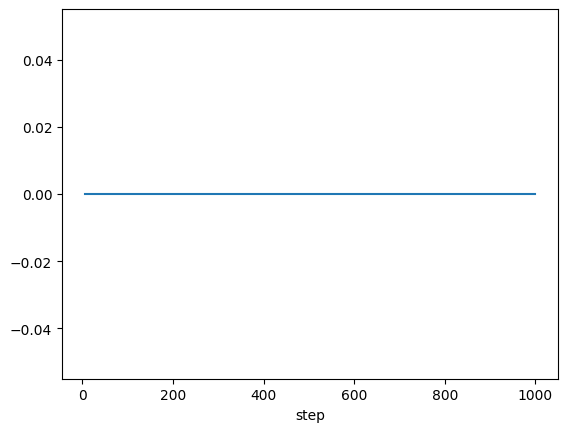

In [36]:
df_single_episode.action.plot()

In [15]:
results = []
for _, row in df_single_episode.iterrows():
    obs = [float(s.strip()) for s in row.obs.split(',')]
    state = agent.get_state(to_tensor(obs))
    option_distributions_dict = {}
    for option in range(0, df_single_episode.option.max() + 1):
        dist = get_action_dist(agent, state, option)[0]
        for i, value in enumerate(dist):
            if i not in option_distributions_dict:
                option_distributions_dict[i] = {'action': i}
            option_distributions_dict[i][f'prob_option_{option}'] = value        
    results.append(option_distributions_dict)
avg_dist = {key: {'action': key, 'prob_option_0': 0, 'prob_option_1': 0} for key in results[0].keys()}
for item in results:
    for key, value in item.items():
        for option in range(n_options):
            option_prob = f'prob_option_{option}'
            avg_dist[key][option_prob] += value[option_prob]
for _, value in avg_dist.items():
    for option in range(n_options):
        option_prob = f'prob_option_{option}'
        value[option_prob] = value[option_prob] / len(results)
df_avg_action_distributions = pd.DataFrame(list(avg_dist.values()))
px.bar(
    data_frame = df_avg_action_distributions,
    x = "action",
    y = [f'prob_option_{option}' for option in range(n_options)],
    opacity = 0.9,
    orientation = "v",
    barmode = 'group',
)

NameError: name 'n_options' is not defined

In [ ]:
results = []
for _, row in df_single_episode.iterrows():
    obs = [float(s.strip()) for s in row.obs.split(',')]
    state = agent.get_state(to_tensor(obs))
    option_distributions_dict = {}
    for option in range(0, df_single_episode.option.max() + 1):
        dist = get_action_dist(agent, state, option)[0]
        for i, value in enumerate(dist):
            if i not in option_distributions_dict:
                option_distributions_dict[i] = {'action': i}
            option_distributions_dict[i][f'prob_option_{option}'] = value        
    results.append(option_distributions_dict)
avg_dist = {key: {'action': key, 'prob_option_0': 0, 'prob_option_1': 0} for key in results[0].keys()}
n_options = 2
for item in results:
    for key, value in item.items():
        for option in range(n_options):
            option_prob = f'prob_option_{option}'
            avg_dist[key][option_prob] += value[option_prob]
for _, value in avg_dist.items():
    for option in range(n_options):
        option_prob = f'prob_option_{option}'
        value[option_prob] = value[option_prob] / len(results)
df_avg_action_distributions = pd.DataFrame(list(avg_dist.values()))
px.bar(
    data_frame = df_avg_action_distributions,
    x = "action",
    y = [f'prob_option_{option}' for option in range(n_options)],
    opacity = 0.9,
    orientation = "v",
    barmode = 'group',
)

In [ ]:
df_action_encoded = pd.get_dummies(df_single_episode[['action', 'option']], columns=['action', ])

In [ ]:
df_action_encoded.groupby('option').sum()

In [ ]:
lanes = ['n_t_0', 'n_t_1', 'e_t_0', 'e_t_1', 's_t_0', 's_t_1', 'w_t_0', 'w_t_1']
          0          1         2       3         4         5     6        7

In [ ]:
# backup
option_distributions = []
for option in range(0, df_single_episode.option.max() + 1):
    dist = get_action_dist(agent, state, option)[0]
    for i, value in enumerate(dist):
        dist_dict = {
            'option': option
        }
        dist_dict[f'action'] = i
        dist_dict[f'prob'] = value
        option_distributions.append(dist_dict)
df_option_distributions = pd.DataFrame(option_distributions)
fig, ax = plt.subplots()

for key, grp in df_option_distributions.groupby(['option']):
    key = key[0]
    ax = grp.plot(ax=ax, kind='line', x='action', y='prob', label=key)

plt.legend(loc='best')
plt.show()